In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Setup

Is there a significant difference in the amount pledged between the Performances, Theater, and Music Kickstarter categories?

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


# Read kickstarter data
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "kickstarterprojects"

conn_str = f"postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}"

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

Write a query to get the `category` and amount `pledged` for the `Performances`, `Theater`, and `Music` categories from the `ksprojects` table.

In [3]:
query = """
    SELECT 
        category,
        pledged
    FROM 
        ksprojects
    WHERE category IN ('Performances', 'Theater', 'Music')
"""

<IPython.core.display.Javascript object>

Run the query and store the output to a pandas DataFrame.

In [4]:
ks = pd.read_sql_query(query, conn_str)
ks.head(3)

,category,pledged
0,Theater,6575.0
1,Theater,1515.0
2,Theater,800.0


<IPython.core.display.Javascript object>

In [5]:
ks["category"].value_counts()

Music           2740
Theater         1376
Performances     158
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
ks.isna().sum()

category    0
pledged     0
dtype: int64

<IPython.core.display.Javascript object>

Descriptively, how do the groups compare?  Make some visualization or print out some stats. 

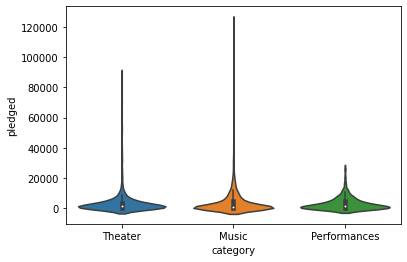

<IPython.core.display.Javascript object>

In [7]:
sns.violinplot("category", "pledged", data=ks)
plt.show()

Let's separate the data into 3 different dataframes for analysis.

In [8]:
# SELECT *
# FROM ks
# WHERE category = 'Music'
music = ks[ks["category"] == "Music"]
thtr = ks[ks["category"] == "Theater"]
perf = ks[ks["category"] == "Performances"]

<IPython.core.display.Javascript object>

## ANOVA Assumption Check

We have 3 groups and we want to compare their means.  This should trigger your ANOVA neurons to start firing, but we need to make sure our assumption of normality is met before performing this test.  To check for normality we could use any of the methods we've covered.  Here, let's look at QQ plots for each sample.

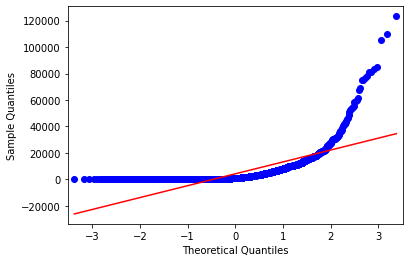

<IPython.core.display.Javascript object>

In [9]:
qqplot(music["pledged"], line="s")
plt.show()

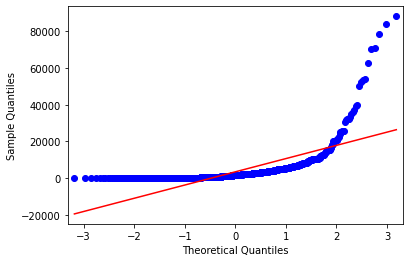

<IPython.core.display.Javascript object>

In [10]:
qqplot(thtr["pledged"], line="s")
plt.show()

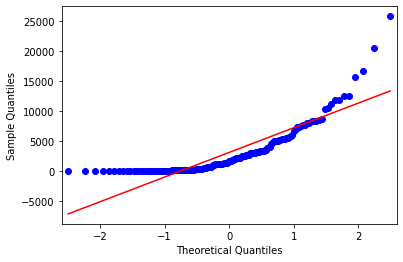

<IPython.core.display.Javascript object>

In [11]:
qqplot(perf["pledged"], line="s")
plt.show()

## Kruskal Wallis

Not looking too normal based on those plots... a non-parametric ANOVA test is the Kruskal Wallis test.  This uses the ranks of our data values rather than the values themselves a good write-up/example of this can be found [here](https://www.statisticshowto.datasciencecentral.com/kruskal-wallis/).  The below list of assumptions is from that linked resource.

> #### Assumptions for the Kruskal Wallis Test
> Your variables should have:
>
> * One independent variable with two or more levels (independent groups). The test is more commonly used when you have three or more levels. For two levels, consider using the Mann Whitney U Test instead.
> * Ordinal scale, Ratio Scale or Interval scale dependent variables.
> * Your observations should be independent. In other words, there should be no relationship between the members in each group or between groups.
> * All groups should have the same shape distributions.

One way to examine the shape could be a histograms by group.  We're roughly the same shape.

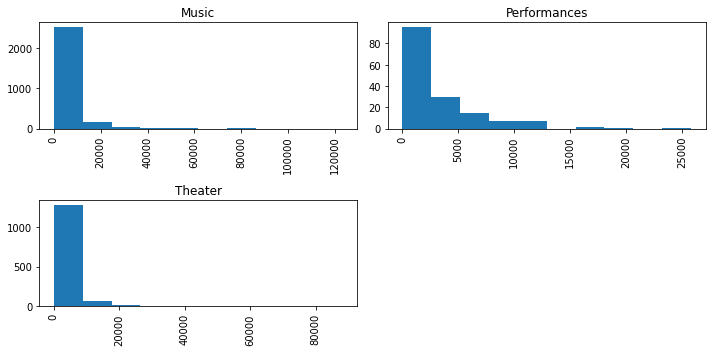

<IPython.core.display.Javascript object>

In [12]:
# in general, to make it bigger use figure
# plt.figure(figsize=(10, 5))

ks.hist(by="category", figsize=(10, 5))
plt.tight_layout()
plt.show()

Let's move on to performing the test with `scipy.stats`.  Note, that we call this the same way as `stats.f_oneway` (for performing an ANOVA with `scipy.stats`).

* $H_o$: there is no difference in medians
* $H_a$: there is at least one median that is different

In [13]:
_, p = stats.kruskal(thtr["pledged"], music["pledged"], perf["pledged"])
p < 0.05

True

<IPython.core.display.Javascript object>

## Kruskal Post Hoc

So we've concluded at least one median is different.  Time for some post hoc analysis.  We'll be doing multiple tests to determine this, so we need to correct for this compounding chance of a Type I error.

Let's use [`stats.mannwhitneyu()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) to perform these follow up tests. We could possibly reuse the kruskal wallis to acheive the same results; kruskal wallis is a generalization of the mann whitney test to extend it to `n_groups > 2`.

* Perform 3 `stats.mannwhitneyu()` tests to compare each pair of our 3 groups.
* Save all of the outputted p-values to a list.

In [14]:
_, p1 = stats.mannwhitneyu(thtr["pledged"], music["pledged"])
_, p2 = stats.mannwhitneyu(thtr["pledged"], perf["pledged"])
_, p3 = stats.mannwhitneyu(music["pledged"], perf["pledged"])

p_values = [p1, p2, p3]

<IPython.core.display.Javascript object>

In [15]:
p_values

[6.683887451901247e-06, 0.30161529865779246, 0.1836774034609001]

<IPython.core.display.Javascript object>

### Multiple Testing

As mentioned above, we have added risk of committing a Type I error when performing repeated tests like this (Type 1 error - rejecting null when there's really no effect).    The `statsmodels` package provides a [`multipletests()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html) function that can help us mitigate this risk of error (this function was imported at the top of the notebook).

* Use `multipletests()` with your list of p-values to correct for multiple tests.
* What are our conclusions from this analysis?

In [16]:
reject, corr_p, sidak, bonf = multipletests(p_values, alpha=0.05)

<IPython.core.display.Javascript object>

In [17]:
reject

array([ True, False, False])

<IPython.core.display.Javascript object>

In [18]:
corr_p

array([2.00515283e-05, 3.33617418e-01, 3.33617418e-01])

<IPython.core.display.Javascript object>

In [19]:
sidak

0.016952427508441503

<IPython.core.display.Javascript object>

In [20]:
bonf

0.016666666666666666

<IPython.core.display.Javascript object>

Based on our analysis we found:
* The mean rank of at least one of our samples is significantly different than the others
* There is a significant difference in mean rank between the amount pledged for theater and the amount pledged for music

### Confidence Interval

In [21]:
def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

The confidence interval formula above has the process of:

1. Find the difference between each pair of observations between the 2 groups
  * if `x1 = [1, 2]` and `x2 = [1, 2, 3]`
  * then it would calculate:
    * `[1 - 1, 1 - 2, 1 - 3, 2 - 1, 2 - 2, 2 - 3]`
    * `[0, -1, -2, 1, 0, -1]`
* Sort the differences
  * `[0, -1, -2, 1, 0, -1]` -> `[-2, -1, -1, 0, 0, 1]`
* Based on sample size and alpha, choose an appropriate value of `k`, which will be used to choose the start and stop of the CI.
  * if `k = 2` in our example our interval would be `(-1, 0)`
     * `diffs = [-2, -1, -1, 0, 0, 1]`
     * `(diffs[k], diffs[-k])`  
  * See function code for details of choosing `k`.  For two samples of size `10`, you would have `100` pairwise differences, and the value of `k` (for an `alpha = 0.05`) would be `24`.  So the confidence interval would be the 24th and the 76th diffs.

In [22]:
print(thtr["pledged"].median())
print(music["pledged"].median())

1604.5
952.5


<IPython.core.display.Javascript object>

In [23]:
calc_non_param_ci(thtr["pledged"], music["pledged"])

(48.0, 230.0)

<IPython.core.display.Javascript object>

### Effect Size

#### Common language effect size

For the effect size of a Mann Whitney test we might use the 'common-language effect size'.

> What is the ‘common-language effect size’?
In 1992, [McGraw and Wong](http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361) introduced the common-language effect size, which they defined as
>
> "the probability that a score sampled at random from one distribution will be greater than a score sampled from some other distribution."

In [24]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

In [25]:
cles_ind(thtr["pledged"], music["pledged"])

0.5365979354099474

<IPython.core.display.Javascript object>

This effect size is saying that if we randomly choose a pledged amount from theater and randomly choose a pledged amount from music, then there's a 53% chance the theater value is larger.  So although we have a significant test result.  This isn't looking like a huge effect.

#### Rank-biserial correlation coefficient

This sounds intimidating, but it has the same idea as a pearson correlation coefficient (what you think of when you think of a correlation; what you get if you run `df.corr()`).  This is a way to measure a correlation between a binary variable and a numeric variable.  In our mann-whitney test we have 2 groups (binary) and we're comparing numeric data, so this approach to effect size is to indicate the strength of the relationship between the grouping variable and the numeric variable.

In the implementation below, the `rbc` ranges from (0, 1).  If the correlation coefficient is close to zero, then it's indicating a weaker relationship.  If the value is closer to one, then it's indicating a stronger relationship.

In [26]:
def rbc_ind(x1, x2):
    """Calculate rank-biserial correlation coefficient

    Output values range from [0, 1]; interpret as:
      * Values closer to 0 are a weaker effect
      * Values closer to 1 are a stronger effect

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) rank-biserial correlation coefficient
    """
    n1 = x1.size
    n2 = x2.size

    u, _ = stats.mannwhitneyu(x1, x2)
    rbc = 1 - (2 * u) / (n1 * n2)

    return rbc


<IPython.core.display.Javascript object>

In [27]:
rbc_ind(thtr["pledged"], music["pledged"])

0.08301116109319295

<IPython.core.display.Javascript object>

This tells a similar story to the common language effect size.  We have a statistically significant difference, but this difference doesn't appear to be an overwhelmingly large one.

----

**Extra practice**

Repeat the post hoc analysis but using the kruskal wallis test in place of the `stats.mannwhitneyu()`.  Remember, you're still performing multiple tests so you should correct for this increased risk of Type 1 error.  Are the conclusions the same?

## Non-parametric paired samples

In this new setup let's say we have kickstarter data for people at time 1 and time 2.  At time 1 we have donations these people made to music category projects and at time 2 we have donation these same people made to theater projects.

In [28]:
# reformatting data for new setup
n = min(thtr["pledged"].size, music["pledged"].size)

t1 = thtr["pledged"].values[:n]
t1.sort()

t2 = music["pledged"].values[:n]
t2.sort()

df = pd.DataFrame({"theater": t1, "music": t2})

<IPython.core.display.Javascript object>

If we were wanting to perform a paired t-test we need to check the normality assumption.

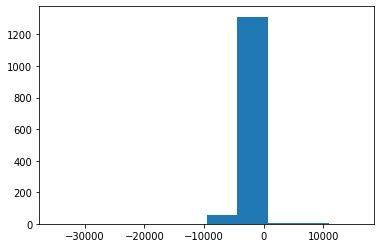

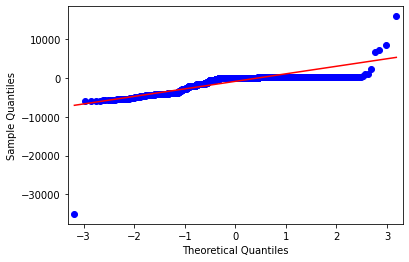

<IPython.core.display.Javascript object>

In [29]:
df["diff"] = df["theater"] - df["music"]

plt.hist(df["diff"])
plt.show()

qqplot(df["diff"], line="s")
plt.show()

A Wilcoxon signed-rank test is a non-parametric version of the paired t-test.  See the `scipy` documentation below for the intuition of the test.

> The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

In [30]:
stats.wilcoxon(df["theater"], df["music"])

WilcoxonResult(statistic=303919.5, pvalue=5.8904511169958e-16)

<IPython.core.display.Javascript object>

### Effect size

For effect size, we can use modified versions of common language effect size and the rank-biserial correlation coefficient.

#### Common-language effect size

In [31]:
def cles_rel(x1, x2):
    """Calc common language effect size for paired samples

    Interpret as the probability that a pair's difference (x1 - x2)
    sampled at random will be greater than 0.

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diffs = x1 - x2
    # Convert differences to 0.0, 0.5, or 1.0:
    #   * 0.0 if x1 < x2
    #   * 0.5 if x1 == x2
    #   * 1.0 if x1 > x2
    diffs = np.where(diffs == 0.0, 0.5, diffs > 0)

    # Take average of array with [0s, 0.5s, 1s]
    # This indicates prob of pulling a random
    # diff and it being greater than 0
    return diffs.mean()

<IPython.core.display.Javascript object>

In [32]:
cles_rel(df["theater"], df["music"])

0.5668604651162791

<IPython.core.display.Javascript object>

According to this, if we grab any person from our dataset, theres a 57% chance they pledged more to theather than to music.

#### Rank-biserial correlation coefficient

This implementation outputs values ranging from (-1, 1).  A `-1` indicates that group 2 is larger, `1` indicates that group 1 is larger, & `0` indicates that the groups are not very different.

In [33]:
def rbc_rel(x1, x2):
    """Calculate rank-biserial correlation coefficient for paired samples

    Output values range from [-1, 1]; interpret as:
      * Values closer to 1 indicate that x1 is larger
      * Values closer to -1 indicate that x2 is larger

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) rank-biserial correlation coefficient
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diffs = x1 - x2
    diffs = diffs[diffs != 0]
    diff_ranks = stats.rankdata(abs(diffs))

    rank_sum = diff_ranks.sum()
    pos_rank_sum = np.sum((diffs > 0) * diff_ranks)
    neg_rank_sum = np.sum((diffs < 0) * diff_ranks)
    rbc = pos_rank_sum / rank_sum - neg_rank_sum / rank_sum

    return rbc

<IPython.core.display.Javascript object>

In [34]:
rbc_rel(df["theater"], df["music"])

-0.26089885372499855

<IPython.core.display.Javascript object>

When viewing this as paired sample data, we see a stronger effect than when we were working with this data as independent.

Note, in reality we have no reason to consider this as paired data.  It was just made up to show an example without introducing a new dataset. In practice, you don't have the luxury of just deciding whether to use paired or independent methods.